# 동적자산 배분

## BAA (Balanced Asset Allocation)
12개 ETF 중 상대 모멘텀을 통해 최근 많이 오른 ETF를 사고, VAA와 마찬가지로 1-3-6-12 모멘텀 스코어를 활용합니다. 안전 자산은 7개로 VAA의 3개보다 대폭 안전자산이 늘어났습니다. 카나리아 자산군도 DAA의 2개보다 더 늘어났습니다. 안전자산쪽을 보강한 전략으로 최근의 CAGR은 조금 낮지만 MDD도 상당히 낮은 전략입니다. 시장이 침체에 있을 때 괜찮은 전략입니다.

- 안전자산군 대폭 추가와 카나리아 자산군 추가로으로 MDD를 줄이기 때문에 MDD에 강하고 시장이 침체되도 괜찮은 전략

### 포함자산
 - 공격형 자산 : 미국 대형주(SPY), 나스탁(QQQ), 미국 소형주(IWM), 유럽 주식(VGK), 일본주식 (EWJ), 개발도상국 주식(EEM), 미국 부동산리츠(VNQ), 금(GLD), 원자재(DBC), 하이일드 채권(HYG), 미국 회사채(LQD), 미국 장기채(TLT)
 - 안전 자산 : 미국 회사채(LQD), 미국 중기국채(IEF), 미국 단기국채(SHY), BIL(미국초단기국채), TLT(미국장기국채), TIP(미국물가연동국채), DBC(원자재)

### 매수 전략
 - 카나리아 자산군(VWO, BND, SPY, VEA)을 사용하여 공격형자산 / 안전자산 구분
     - 카나리아 자산 군 중에 모멘텀 스코어가 0 이하인 것이 하나라도 있으면 안잔자산으로 이동
     - 카나리아 자산군의 모멘텀이 전부 0 이상이면 공격형 자산 상대 모멘텀이 높은 6개 ETF에 분산투자
 - 모멘텀 스코어 계산\
     (1개월 수익률 X 12) + (3개월 수익률 X 4) + (6개월 수익률 X 2) + (12개월 수익률 X 1)
 - 안전자산 3개 선택 (현재가격 / 12개월 이동평균)이 높은 3개 자산 선택
 - 안전자산도 가격이 12개월 이평보다 낮을 경우 현금으로 이동
 
### 매도 전략
 - 월 1회 리밸런싱

                    Strategy
------------------  ----------
Start Period        2010-01-31
End Period          2022-09-30
Risk-Free Rate      0.0%
Time in Market      99.0%

Cumulative Return   224.66%
CAGR﹪              9.74%

Sharpe              5.59
Prob. Sharpe Ratio  100.0%
Sortino             11.44
Sortino/√2          8.09
Omega               2.62

Max Drawdown        -12.77%
Longest DD Days     1006

Gain/Pain Ratio     1.62
Gain/Pain (1M)      1.62

Payoff Ratio        1.59
Profit Factor       2.62
Common Sense Ratio  4.95
CPC Index           2.6
Tail Ratio          1.89
Outlier Win Ratio   3.64
Outlier Loss Ratio  3.27

MTD                 -2.21%
3M                  -5.56%
6M                  0.1%
YTD                 3.19%
1Y                  1.58%
3Y (ann.)           13.51%
5Y (ann.)           12.88%
10Y (ann.)          8.49%
All-time (ann.)     9.74%

Avg. Drawdown       -2.52%
Avg. Drawdown Days  124
Recovery Factor     17.59
Ulcer Index         0.05
Serenity Index      11.

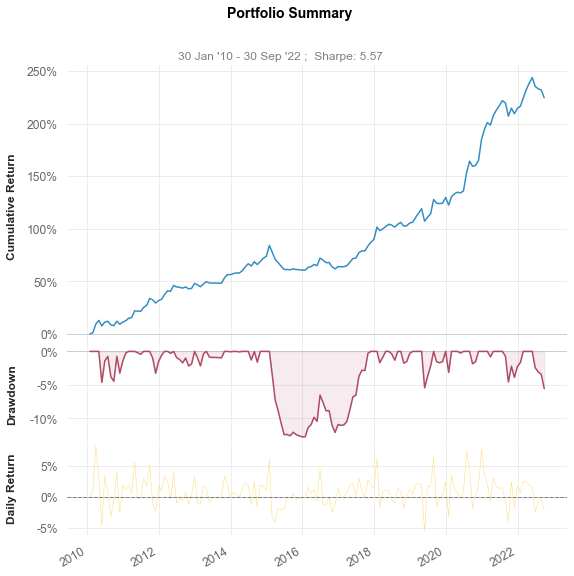

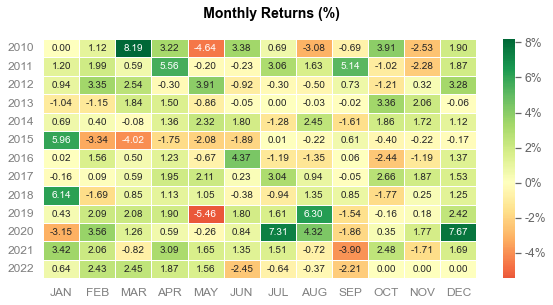

In [7]:
# 필요 라이브러리 import
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quantstats as qs

# pandas 설정 및 메타데이터 세팅
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

start_day = datetime(2010,1,1) # 시작일
end_day = datetime(2022,9,30) # 종료일

# RU : Risky Universe
# DU : Defence Universe
# CU : Canaria Universe
RU = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'GLD', 'DBC', 'HYG', 'LQD', 'TLT']
DU = ['LQD','SHY','IEF', 'BIL', 'TLT', 'TIP', 'DBC']
CU = ['VWO', 'BND', 'SPY', 'VEA']
TU = list(set(RU+DU+CU)) # LQD 중복 제거

# 데이터 추출 함수
def get_price_data(TU, CU):
    df_TU = pd.DataFrame(columns=TU)
    df_CU = pd.DataFrame(columns=CU)
    
    for ticker in TU:
        df_TU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
    
    for ticker in CU:
        df_CU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
     
    return df_TU, df_CU

# 각 자산 군의 데이터 추출
df_TU, df_CU = get_price_data(TU, CU)

# 모멘텀 지수 계산 함수
def get_momentum(x):
    temp_list = [0 for i in range(len(x.index))]
    momentum = pd.Series(temp_list, index=x.index)

    try:
        before1 = df_TU[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1][TU]
        before3 = df_TU[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1][TU]        
        before6 = df_TU[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1][TU]        
        before12 = df_TU[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1][TU]

        momentum = 12 * (x / before1 - 1) + 4 * (x / before3 - 1) + 2 * (x / before6 - 1) + (x / before12 - 1)
    except Exception as e:
        #print("Error : ", str(e))
        pass
    
    return momentum

# 각 자산별 모멘텀 지수 계산
mom_col_list = [col+'_M' for col in df_TU[TU].columns]
df_TU[mom_col_list] = df_TU[TU].apply(lambda x: get_momentum(x), axis=1)

# 카나리아를 통한 안전자산 비중 측정
def get_canaria_ratio(x):
    asset = pd.Series([0, 0], index=['MMT_ASSET', 'RATIO'])
    
    # 모멘텀 < 0 갯수 계산
    momentum_asset = [1 if x[ticker+'_M'] < 0 else 0 for ticker in CU]
    # 모멘텀 < 0 인게 하나라도 있으면 안전자산으로 이동
    DU_ratio = 1 if sum(momentum_asset) > 0 else 0
    

    asset['MMT_ASSET'] = int(sum(momentum_asset))
    asset['RATIO'] = round(DU_ratio, 2)
    
    return asset

# 매월 선택할 자산과 가격
df_TU[['MMT_ASSET', 'RATIO']] = df_TU.apply(lambda x: get_canaria_ratio(x), axis=1)

# 안전자산의 12개월 이평선
mom_col_list = [col+'_12M' for col in df_TU[DU].columns]
df_TU[mom_col_list] = df_TU[DU].rolling(window=240).mean()
df_TU.fillna(0)

# 백테스트할 기간 데이터 추출
df_TU = df_TU[start_day:end_day]

# 매월 말일 데이터만 추출(리밸런싱에 사용)
df_TU = df_TU.resample(rule='M').last()

# 안전자산 모멘텀 계산 (mom = 현재가 / 12개월 이평선)
mom_du_list = [col+'_DUM' for col in df_TU[DU].columns]
for i in range(len(mom_du_list)):
    df_TU[mom_du_list[i]] = df_TU[mom_du_list[i][:3]] / df_TU[mom_du_list[i][:3]+'_12M']
    
# 모멘텀 지수 계산 함수
def get_momentum_RU(x):
    asset = pd.Series([0, 0, 0, 0, 0, 0], index=['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6'])
    
    momentum_cols = [ticker + '_M' for ticker in RU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index
    
    asset['RRANK1'] = select_momentum[0][:3]
    asset['RRANK2'] = select_momentum[1][:3]
    asset['RRANK3'] = select_momentum[2][:3]
    asset['RRANK4'] = select_momentum[3][:3]
    asset['RRANK5'] = select_momentum[4][:3]
    asset['RRANK6'] = select_momentum[5][:3]
    
    return asset

# 모멘텀 지수 계산 함수
def get_momentum_DU(x):
    asset = pd.Series([0, 0, 0], index=['DRANK1', 'DRANK2', 'DRANK3'])
    
    momentum_cols = [ticker + '_DUM' for ticker in DU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index

    asset['DRANK1'] = select_momentum[0][:3]
    asset['DRANK2'] = select_momentum[1][:3]
    asset['DRANK3'] = select_momentum[2][:3]
    
    return asset


# 공격자산 모멘텀 상위 6개 자산군 구하기
df_TU[['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6']] = df_TU.apply(lambda x : get_momentum_RU(x), axis=1)

# 방어자산 모멘텀 상위 3개 자산구하기
df_TU[['DRANK1', 'DRANK2', 'DRANK3']] = df_TU.apply(lambda x : get_momentum_DU(x), axis=1)

# 카나리아를 통한 안전자산 비중 측정
def get_du_ratio(x):
    asset = pd.Series([0, 0.0], index=['DUM_ASSET', 'DU_RATIO'])
    
    drank_cols = ['DRANK1', 'DRANK2', 'DRANK3']
    momentum_asset = [1 if x[x[cols]+'_DUM'] > 1 else 0 for cols in drank_cols]
    DU_ratio =  float(sum(momentum_asset) / 3)
    
    asset['DUM_ASSET'] = int(sum(momentum_asset))
    asset['DU_RATIO'] = DU_ratio
    
    return asset

drank_cols = ['DRANK1', 'DRANK2', 'DRANK3']
df_TU[['DUM_ASSET', 'DU_RATIO']] = df_TU.apply(lambda x: get_du_ratio(x), axis=1)

# 각 자산별 수익률 계산
profit_col_list = [col+'_P' for col in df_TU[TU].columns]
df_TU[profit_col_list] = df_TU[TU].pct_change() * 100

# 매월 수익률 & 누적 수익률 계산
df_TU['PROFIT'] = 0

for i in range(len(df_TU)):
    profit = 0
    log_profit = 0
        
    if i != 0:
        ratio = df_TU.iloc[i-1]['RATIO']
        RU_ratio = (1.0 - ratio)
        
        if ratio == 1:
            DU_ratio = df_TU.iloc[i-1]['DU_RATIO']
            DUM_asset = df_TU.iloc[i-1]['DUM_ASSET']

            if DUM_asset == 3.0:
                profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * (DU_ratio/3)
                profit2 = df_TU[df_TU.iloc[i-1]['DRANK2'] + '_P'].iloc[i] * (DU_ratio/3)
                profit3 = df_TU[df_TU.iloc[i-1]['DRANK3'] + '_P'].iloc[i] * (DU_ratio/3)
            elif DUM_asset == 2.0:
                profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * (DU_ratio/2)
                profit2 = df_TU[df_TU.iloc[i-1]['DRANK2'] + '_P'].iloc[i] * (DU_ratio/2)
                profit3 = df_TU['BIL_P'].iloc[i] * (DU_ratio/2)
            elif DUM_asset == 1.0:
                profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * (DU_ratio)
                profit2 = df_TU['BIL_P'].iloc[i] * (DU_ratio*2)
                profit3 = 0.0
            else:
                profit1 = df_TU['BIL_P'].iloc[i]
                profit2 = 0.0
                profit3 = 0.0
        
        profit4 = df_TU[df_TU.iloc[i-1]['RRANK1'] + '_P'].iloc[i] * (RU_ratio/6)
        profit5 = df_TU[df_TU.iloc[i-1]['RRANK2'] + '_P'].iloc[i] * (RU_ratio/6)
        profit6 = df_TU[df_TU.iloc[i-1]['RRANK3'] + '_P'].iloc[i] * (RU_ratio/6)
        profit7 = df_TU[df_TU.iloc[i-1]['RRANK4'] + '_P'].iloc[i] * (RU_ratio/6)
        profit8 = df_TU[df_TU.iloc[i-1]['RRANK5'] + '_P'].iloc[i] * (RU_ratio/6)
        profit9 = df_TU[df_TU.iloc[i-1]['RRANK6'] + '_P'].iloc[i] * (RU_ratio/6)

        profit = profit1 + profit2 + profit3 + profit4 + profit5 + profit6 + profit7 + profit8 + profit9
    
    df_TU.loc[df_TU.index[i], 'PROFIT'] = profit
    
# QuantStats의 기본 리포트
qs.reports.basic(df_TU['PROFIT']/100)

In [8]:
df_TU

,BND,GLD,SPY,SHY,TIP,VWO,IEF,IWM,DBC,VNQ,VEA,LQD,EEM,QQQ,VGK,HYG,EWJ,BIL,TLT,BND_M,GLD_M,SPY_M,SHY_M,TIP_M,VWO_M,IEF_M,IWM_M,DBC_M,VNQ_M,VEA_M,LQD_M,EEM_M,QQQ_M,VGK_M,HYG_M,EWJ_M,BIL_M,TLT_M,MMT_ASSET,RATIO,LQD_12M,SHY_12M,IEF_12M,BIL_12M,TLT_12M,TIP_12M,DBC_12M,LQD_DUM,SHY_DUM,IEF_DUM,BIL_DUM,TLT_DUM,TIP_DUM,DBC_DUM,RRANK1,RRANK2,RRANK3,RRANK4,RRANK5,RRANK6,DRANK1,DRANK2,DRANK3,DUM_ASSET,DU_RATIO,BND_P,GLD_P,SPY_P,SHY_P,TIP_P,VWO_P,IEF_P,IWM_P,DBC_P,VNQ_P,VEA_P,LQD_P,EEM_P,QQQ_P,VGK_P,HYG_P,EWJ_P,BIL_P,TLT_P,PROFIT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-31,55.8680,105.9600,84.2029,75.0762,77.0406,27.4885,70.9773,50.4328,22.0459,25.8408,22.2047,67.7749,29.7396,37.9480,28.9735,41.5727,32.1405,87.0038,66.1253,0.3312,0.4790,0.1185,0.1459,0.4992,0.3270,0.2448,0.2197,-1.0411,0.4150,-0.2960,0.3759,0.0790,-0.0632,-0.4230,0.3603,0.3504,0.0056,0.0647,1,1,63.5618,74.3042,70.5959,86.9644,67.4418,73.1808,21.7696,1.0663,1.0104,1.0054,1.0005,0.9805,1.0527,1.0127,GLD,VNQ,LQD,HYG,EWJ,IWM,LQD,TIP,DBC,3.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
2010-02-28,56.0497,109.4300,86.8296,75.1966,76.0366,28.0061,71.2129,52.6898,22.9592,27.2835,22.3695,68.1183,30.2679,39.6951,28.8141,42.3516,32.4672,86.9848,65.8988,0.2042,0.6384,0.8264,0.0841,0.0196,1.1391,0.0501,1.3584,0.4890,2.1776,0.1200,0.3714,0.9303,0.9769,-0.2365,0.9079,0.4534,-0.0011,-0.2330,0,0,64.3321,74.4033,70.5384,86.9677,66.9345,73.7724,22.1120,1.0589,1.0107,1.0096,1.0002,0.9845,1.0307,1.0383,VNQ,IWM,QQQ,EEM,HYG,SPY,LQD,DBC,TIP,3.0000,1.0000,0.3252,3.2748,3.1195,0.1604,-1.3032,1.8828,0.3319,4.4752,4.1428,5.5832,0.7421,0.5067,1.7764,4.6039,-0.5501,1.8734,1.0163,-0.0218,-0.3425,1.1154
2010-03-31,55.9254,108.9500,92.1158,74.9943,76.0322,30.2992,70.4603,57.0265,22.8523,30.0629,23.7778,68.5623,32.7229,42.7560,30.6887,43.2551,34.1003,86.9848,64.5430,0.1110,0.4304,1.6223,0.0172,0.0984,1.9645,-0.1456,2.0325,0.2317,3.1474,1.3985,0.4169,1.7865,1.9144,1.3814,0.9728,1.3100,0.0056,-0.5140,0,0,65.3666,74.5053,70.3711,86.9687,66.2750,74.1991,22.3858,1.0489,1.0066,1.0013,1.0002,0.9739,1.0247,1.0208,VNQ,IWM,QQQ,EEM,SPY,VGK,LQD,TIP,DBC,3.0000,1.0000,-0.2217,-0.4386,6.0880,-0.2691,-0.0057,8.1879,-1.0568,8.2307,-0.4655,10.1868,6.2956,0.6519,8.1109,7.7109,6.5058,2.1335,5.0302,0.0000,-2.0574,8.1922
2010-04-30,56.5240,115.3600,93.5408,75.2193,77.9445,30.2345,71.6248,60.2647,23.7462,32.2124,23.1184,69.8704,32.6685,43.7148,29.5218,44.0876,33.9370,86.9469,66.6871,0.2956,1.6330,1.3319,0.0743,0.5171,1.1822,0.2564,2.5170,1.0732,3.2664,0.2372,0.6145,1.1222,1.7313,-0.0558,0.9585,0.6003,-0.0098,0.3732,0,0,66.1816,74.5935,70.3120,86.9690,65.9527,74.6997,22.6940,1.0557,1.0084,1.0187,0.9997,1.0111,1.0434,1.0464,VNQ,IWM,QQQ,GLD,SPY,EEM,LQD,DBC,TIP,3.0000,1.0000,1.0703,5.8834,1.5470,0.3001,2.5150,-0.2135,1.6527,5.6785,3.9116,7.1501,-2.7730,1.9079,-0.1662,2.2425,-3.8022,1.9245,-0.4789,-0.0436,3.3219,3.2237
2010-05-31,57.1612,118.8800,86.1085,75.5600,78.0939,27.4598,73.7257,55.7228,21.3366,30.4940,20.4536,68.9563,29.5997,40.4832,26.0532,42.0263,31.0627,86.9848,70.0937,0.3825,1.1530,-0.7970,0.1246,0.3446,-1.0115,0.6955,-0.0902,-1.5658,1.1029,-1.8446,0.1513,-1.0711,-0.4240,-2.0212,-0.2059,-0.9965,0.0029,1.2044,3,1,66.8982,74.7245,70.6607,86.9706,66.3877,75.2419,22.6355,1.0308,1.0112,1.0434,1.0002,1.0558,1.0379,0.9426,TLT,GLD,VNQ,LQD,IWM,HYG,TLT,IEF,TIP,3.0000,1.0000,1.1273,3.0513,-7.9455,0.4529,0.1916,-9.1774,2.9332,-7.5366,-10.1473,-5.3346,-11.5270,-1.3083,-9.3936,-7.3924,-11.7495,-4.6755,-8.4697,0.0436,5.1083,-4.6432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,75.9027,171.1400,409.4719,82.9060,114.3855,42.7402,102.